# Network speed and household carbon emissions

# Statement

I verify that I am the sole author of the programmes contained in this archive, except where explicitly stated to the contrary

Signature: Juncai Yang
Date: 2022/08/08

*Part of the code is quoted from the course 7CUSMSDA Spatial Data Analysis.

In [1]:
# -*- coding:utf-8 -*-
import geopandas
from shapely.geometry import Point, LineString
from geopandas import GeoDataFrame
# conda install -c conda-forge spaghetti (if using conda)
import spaghetti
import os
import glob
from libpysal.weights import Queen
import pandas as pd
import geopandas as gpd
import networkx as nx
import osmnx
from matplotlib import pyplot as plt
import matplotlib
from pyproj import Proj
import smopy
import seaborn as sns
import collections
import numpy as np
import math
from matplotlib import cm
import esda
from haversine import haversine
from splot.esda import lisa_cluster
from splot.esda import moran_scatterplot, lisa_cluster, plot_moran
import statsmodels.api as sm
import warnings
import pysal as ps
from pysal.viz import mapclassify
import palettable as pltt
from seaborn import palplot
import zipfile
import folium  
from spreg import OLS
from spreg import ML_Error
from spreg import ML_Lag
import libpysal as lps
import matplotlib.pyplot as plt
import esda
import spreg
from sklearn.metrics import mean_squared_error as mse


# GWR prediction libraries
from mgwr.sel_bw import Sel_BW
from mgwr.gwr import GWR
# from pysal.contrib.glm.family import Gaussian
from scipy.stats import pearsonr

warnings.filterwarnings("ignore")

D:\ProgramData\Anaconda3\envs\msda2021\lib\site-packages\spaghetti\network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


In [2]:
# read the file
def read_csv(data_file):
    df = pd.read_csv("./"+data_file)
    # df = adult_df.drop(columns='fnlwgt')
    return df

# 1.1 Access to UK CO2 emissions data

In [3]:
uk_carbon_df = read_csv('./raw_data/carbon_emissions_data/Local Authority territorial carbon dioxide (CO2) emissions estimates 2005-2020 (kt CO2e) - Full dataset.csv')
uk_carbon_df = uk_carbon_df.dropna().reset_index(drop=True)

In [4]:
# Perform data restructuring
arr = uk_carbon_df.values
uk_new_df = pd.DataFrame(arr[1:,1:],index=arr[1:,0],columns=arr[0,1:])
uk_new_df.index.name = arr[0,0]

In [5]:
uk_new_df

,Second Tier Authority,Local Authority,Local Authority Code,Calendar Year,Industry Electricity,Industry Gas,Large Industrial Installations,Industry 'Other',Industry Total,Commercial Electricity,...,Agriculture Soils,Agriculture Total,Landfill,Waste Management 'Other',Waste Management Total,Grand Total,"Population ('000s, mid-year estimate)",Per Capita Emissions (tCO2e),Area (km2),Emissions per km2 (kt CO2e)
Region/Country,,,,,,,,,,,,,,,,,,,,,
North East,Darlington,Darlington,E06000005,2005,60.1,115.6,0.0,36.0,211.7,71.3,...,2.3,11.2,0.0,0.0,0.0,845.9,100.3,8.4,197.5,4.3
North East,Darlington,Darlington,E06000005,2006,64.4,98.4,0.1,35.5,198.2,76.4,...,2.3,11.3,0.0,0.0,0.0,828.0,101.5,8.2,197.5,4.2
North East,Darlington,Darlington,E06000005,2007,60.8,95.9,0.1,36.1,192.9,72.2,...,1.9,10.4,0.0,0.0,0.0,804.5,102.6,7.8,197.5,4.1
North East,Darlington,Darlington,E06000005,2008,60.1,96.2,0.1,34.4,190.8,71.3,...,2.1,10.6,0.0,0.0,0.0,786.8,103.7,7.6,197.5,4.0
North East,Darlington,Darlington,E06000005,2009,52.9,82.8,1.1,22.9,159.8,62.8,...,1.9,9.8,0.0,0.0,0.0,712.9,104.4,6.8,197.5,3.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Northern Ireland,Northern Ireland,"Newry, Mourne and Down",N09000010,2016,58.8,0.0,0.0,214.2,273.0,22.8,...,9.0,70.5,0.0,0.0,0.0,"1,294.6",177.8,7.3,"1,682.3",0.8
Northern Ireland,Northern Ireland,"Newry, Mourne and Down",N09000010,2017,51.7,0.0,0.0,219.1,270.8,16.6,...,7.6,68.3,0.0,0.0,0.0,"1,285.6",179.0,7.2,"1,682.3",0.8
Northern Ireland,Northern Ireland,"Newry, Mourne and Down",N09000010,2018,47.2,0.0,0.0,215.7,262.9,16.4,...,7.8,68.0,0.0,0.0,0.0,"1,271.0",180.0,7.1,"1,682.3",0.8


In [6]:
uk_carbon_df = uk_new_df[uk_new_df['Calendar Year'].isin(['2020'])].rename(columns={'Local Authority Code':'Code'})

In [7]:
uk_carbon_df

,Second Tier Authority,Local Authority,Code,Calendar Year,Industry Electricity,Industry Gas,Large Industrial Installations,Industry 'Other',Industry Total,Commercial Electricity,...,Agriculture Soils,Agriculture Total,Landfill,Waste Management 'Other',Waste Management Total,Grand Total,"Population ('000s, mid-year estimate)",Per Capita Emissions (tCO2e),Area (km2),Emissions per km2 (kt CO2e)
Region/Country,,,,,,,,,,,,,,,,,,,,,
North East,Darlington,Darlington,E06000005,2020,19.3,75.0,0.1,20.0,114.4,16.5,...,1.5,6.9,0.0,0.0,0.0,486.0,107.4,4.5,197.5,2.5
North East,Durham,County Durham,E06000047,2020,97.2,92.1,6.7,134.3,330.2,55.4,...,6.8,48.3,0.0,0.0,0.0,"2,145.7",533.1,4.0,"2,232.6",1.0
North East,Gateshead,Gateshead,E08000037,2020,46.4,73.6,5.1,30.7,155.7,34.6,...,0.3,1.6,0.0,0.0,0.0,908.1,202.0,4.5,144.1,6.3
North East,Hartlepool,Hartlepool,E06000001,2020,40.4,63.6,177.2,15.3,296.4,16.7,...,0.5,2.3,0.0,0.0,0.0,588.2,93.8,6.3,98.3,6.0
North East,Middlesbrough,Middlesbrough,E06000002,2020,11.1,32.9,0.1,12.9,57.0,16.9,...,0.1,1.1,0.0,0.0,0.0,558.3,141.3,4.0,54.6,10.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Northern Ireland,Northern Ireland,Fermanagh and Omagh,N09000006,2020,39.7,1.4,14.9,86.1,142.1,10.4,...,8.8,105.4,0.0,0.0,0.0,"1,429.4",117.3,12.2,"3,012.1",0.5
Northern Ireland,Northern Ireland,Lisburn and Castlereagh,N09000007,2020,25.8,21.1,24.2,92.2,163.4,8.7,...,2.6,16.4,0.0,0.0,0.0,822.1,146.5,5.6,510.4,1.6
Northern Ireland,Northern Ireland,Mid and East Antrim,N09000008,2020,33.5,57.8,11.8,292.8,396.0,7.3,...,4.6,43.8,0.0,0.0,0.0,"1,129.4",139.4,8.1,"1,061.4",1.1


# 1.2 Access to UK broadband data

In [8]:
uk_speed_df = read_csv('./raw_data/broadband_speed_data/2020_Speed_UK.csv').dropna().reset_index(drop=True).rename(columns={'laua':'Code'})

In [9]:
uk_speed_df

,Code,laua_name,Median download speed (Mbit/s),Average download speed (Mbit/s),Maximum download speed (Mbit/s),Average download speed (Mbit/s) for lines < 10Mbit/s,Average download speed (Mbit/s) for lines 10<30Mbit/s,Average download speed (Mbit/s) for lines 30<300Mbit/s,Average download speed (Mbit/s) for SFBB lines,Average download speed (Mbit/s) for UFBB lines,...,Number of connections 30<300 Mbit/s (number of lines),Number of connections >=300 Mbit/s (number of lines),Number of connections >=30 Mbit/s (number of lines),Average data usage (GB),Median data usage (GB),Average data usage (GB) for lines <10Mbits,Average data usage (GB) for lines 10<30Mbit/s,Average data usage (GB) for lines 30<300Mbit/s,Average data usage (GB) for SFBB lines,Average data usage (GB) for UFBB lines
0,S12000033,ABERDEEN CITY,40.0,48.1,1000.0,6.2,18.1,56.1,65.2,546.0,...,56249,1071,57320,440,269,131,266,524,528,746.0
1,S12000034,ABERDEENSHIRE,38.0,39.1,1000.0,5.3,19.3,55.0,56.1,370.7,...,56467,201,56668,416,230,158,291,519,520,877.0
2,E07000223,ADUR,69.2,90.7,484.0,6.6,18.6,96.1,113.4,382.8,...,17048,1092,18140,400,219,111,232,429,438,574.0
3,E07000026,ALLERDALE,39.9,41.9,1000.0,5.0,18.8,55.5,56.0,373.3,...,23772,36,23808,366,183,134,286,384,385,900.0
4,E07000032,AMBER VALLEY,39.9,49.7,1000.0,5.8,18.9,62.4,68.1,393.3,...,29214,511,29725,381,204,116,250,428,431,650.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,W06000006,WREXHAM,40.0,52.7,2363.9,5.6,19.0,61.6,70.2,400.8,...,31341,816,32157,482,273,126,321,569,571,645.0
374,E07000238,WYCHAVON,40.0,47.4,1124.0,5.4,18.9,59.4,61.6,379.3,...,32774,230,33004,405,214,120,267,474,477,817.0
375,E07000128,WYRE,39.5,43.4,1000.0,5.8,18.7,54.7,59.5,643.5,...,25302,205,25507,443,228,175,345,517,517,595.0
376,E07000239,WYRE FOREST,49.2,66.8,1124.0,5.7,18.3,75.7,86.6,394.2,...,25420,900,26320,402,205,111,257,460,463,559.0


# 1.3 Merging broadband data and carbon emissions data

In [10]:
uk_merge_df = pd.merge(uk_carbon_df,uk_speed_df)

In [11]:
uk_research_df=uk_merge_df.loc[:,['Code', 'laua_name','Domestic Electricity','Transport Total','Average download speed (Mbit/s)']]

In [12]:
uk_research_df

,Code,laua_name,Domestic Electricity,Transport Total,Average download speed (Mbit/s)
0,E06000005,DARLINGTON,32.4,166.1,94.1
1,E06000047,COUNTY DURHAM,146.4,768.6,45.4
2,E08000037,GATESHEAD,54.1,382.1,78.3
3,E06000001,HARTLEPOOL,25.4,123.2,100.1
4,E06000002,MIDDLESBROUGH,36.4,250.0,98.1
...,...,...,...,...,...
366,N09000006,FERMANAGH AND OMAGH,36.3,354.7,39.6
367,N09000007,LISBURN AND CASTLEREAGH,45.3,255.2,71.8
368,N09000008,MID AND EAST ANTRIM,43.9,250.6,58.3
369,N09000009,MID ULSTER,45.9,354.5,41.6


# 1.4 Map the borders of the boroughs in the UK

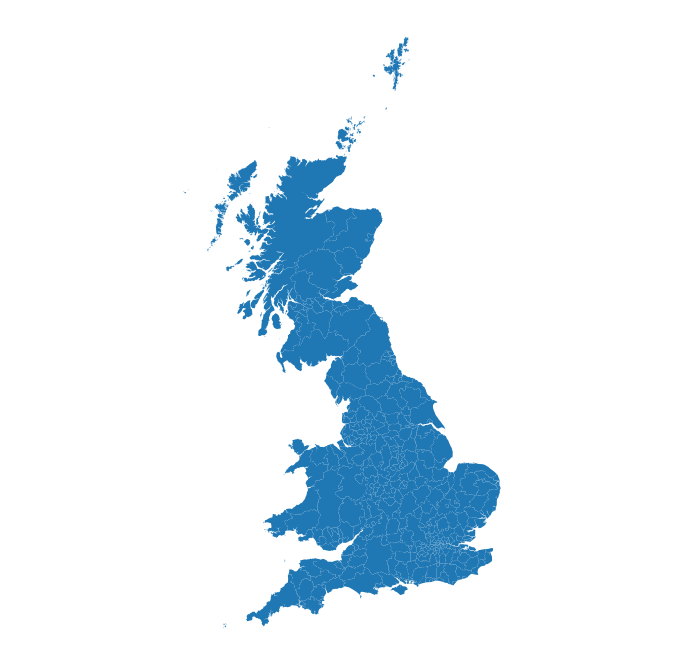

In [13]:
# cited from Week7 codes in Spatial Data Analysis(7CUSMSDA)
uk_map=gpd.read_file('./shapefile/UK_MAP/LAD_DEC_2021_GB_BFC.shp')
# Setup figure and axis with different size
f, ax = plt.subplots(1, figsize=(12, 12))
# Add layer of polygons on the axis
ax.set_axis_off()
uk_map.plot(ax=ax)  # you code here 
plt.axis('equal')
# Display
plt.show() 

# 1.5 Data filtering

In [14]:
# uk_map.columns.to_list()

In [15]:
uk_map = uk_map.rename(columns={'LAD21CD':'Code'})

In [16]:
# uk_map

In [17]:
uk_research_df['Transport Total'] = uk_research_df['Transport Total'].apply(lambda x: x.replace(',', ''))
uk_research_df['Domestic Electricity'] = uk_research_df['Domestic Electricity'].astype(float)
uk_research_df['Transport Total'] = uk_research_df['Transport Total'].astype(float)
uk_df = pd.merge(uk_research_df,uk_map)
uk_df['Domestic Electricity'] = uk_df['Domestic Electricity']/1000
uk_df['Transport Total'] = uk_df['Transport Total']/1000

In [18]:
# Transform coordinate system
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(uk_df, crs=crs)
gdf = gdf.to_crs({'init': 'epsg:27700'})

In [19]:
uk_gdf = gdf.drop(columns=['LAD21NM', 'LAD21NMW','BNG_E','BNG_N','GlobalID'])
uk_gdf.to_file(driver='ESRI Shapefile', filename='./shapefile/UK_MAP/uk_gdf.shp')

# 1.6 Spatial Autocorrelation in UK

In [20]:
y1 = uk_gdf['Average download speed (Mbit/s)'].values
y2 = uk_gdf['Domestic Electricity'].values
y3 = uk_gdf['Transport Total'].values

w = lps.weights.distance.Kernel.from_dataframe(uk_gdf, fixed=False, k=15)
w.transform = 'r'

In [21]:
lisa1 = esda.Moran_Local(y1, w)
lisa2 = esda.Moran_Local(y2, w)
lisa3 = esda.Moran_Local(y3, w)
# moran_loc.Is

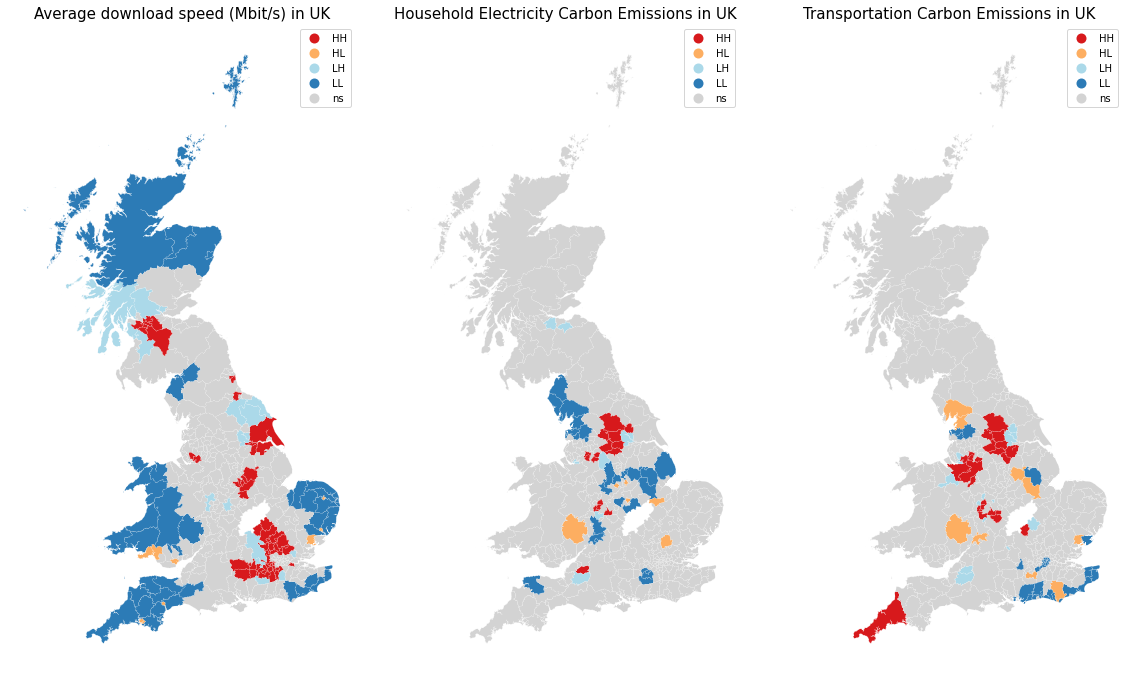

In [22]:
fig,ax=plt.subplots(1,3,figsize=(20,12), subplot_kw=dict(aspect='equal'))
# cited from Week7 codes in Spatial Data Analysis(7CUSMSDA)
fig1 = lisa_cluster(lisa1, uk_gdf, ax=ax[0])
ax[0].set_axis_off()
ax[0].set_title("Average download speed (Mbit/s) in UK", size=15)

fig2 = lisa_cluster(lisa2, uk_gdf, ax=ax[1])
ax[1].set_axis_off()
ax[1].set_title("Household Electricity Carbon Emissions in UK", size=15)

fig3 = lisa_cluster(lisa3, uk_gdf, ax=ax[2])
ax[2].set_axis_off()
ax[2].set_title("Transportation Carbon Emissions in UK", size=15)
# Household Electricity Carbon Emissions in UK
# Transportation Carbon Emissions in UK
plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=-0.3)
plt.show()

In [23]:
mi = esda.moran.Moran(uk_gdf['Average download speed (Mbit/s)'], w) # call moran function
# Household Electricity Carbon Emissions in UK
# Transportation Carbon Emissions in UK
# print out the moran's I value
print("Moran'I: ",mi.I)
print("Moran'p_sim: ",mi.p_sim)

Moran'I:  0.3701115215202307
Moran'p_sim:  0.001


# 1.7 Fisher-Jenks Choropleth

In [24]:
# cited from Week7 codes in Spatial Data Analysis(7CUSMSDA)
imdfj = ps.viz.mapclassify.FisherJenks(uk_gdf['Average download speed (Mbit/s)'], k=5)
imdfj

FisherJenks             

    Interval       Count
------------------------
[ 31.60,  52.10] |    98
( 52.10,  69.20] |    75
( 69.20,  85.00] |    94
( 85.00, 105.30] |    91
(105.30, 163.00] |     2

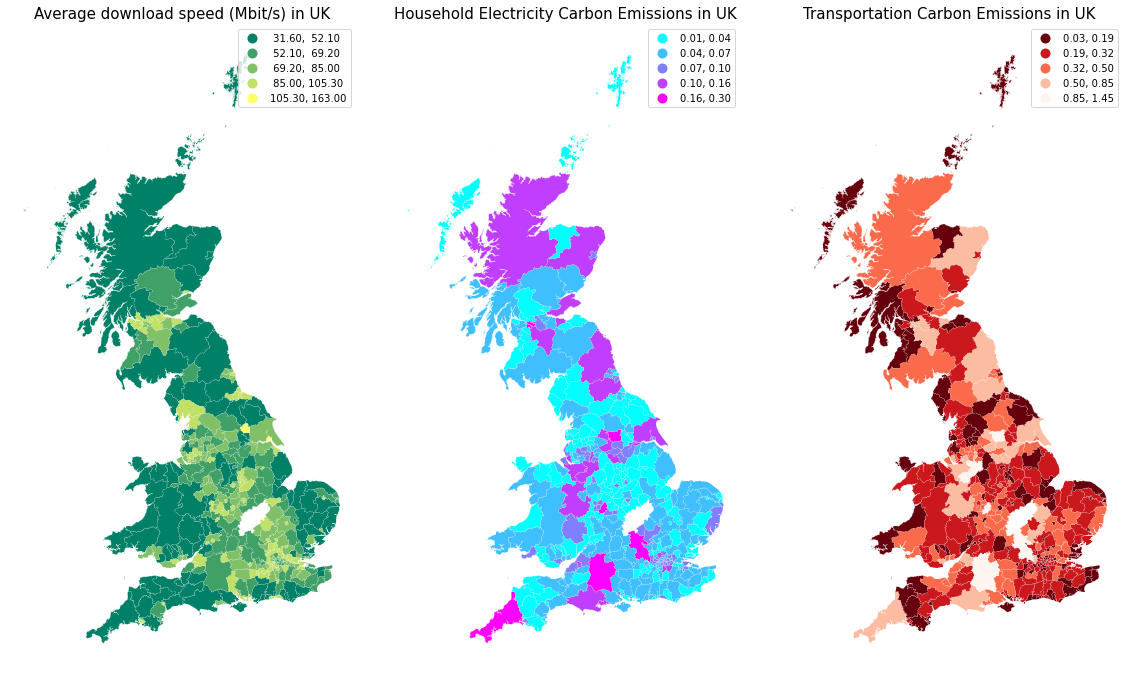

In [25]:
fig,ax=plt.subplots(1,3,figsize=(20,12), subplot_kw=dict(aspect='equal'))
# cited from Week7 codes in Spatial Data Analysis(7CUSMSDA)
uk_gdf.plot(column='Average download speed (Mbit/s)', scheme='FisherJenks', alpha=1, k=5, \
         cmap='summer', 
         edgecolor='w', linewidth=0.1,ax=ax[0], legend=True)
ax[0].set_axis_off()
ax[0].set_title("Average download speed (Mbit/s) in UK", size=15)


uk_gdf.plot(column='Domestic Electricity', scheme='FisherJenks', alpha=1, k=5, \
         cmap='cool', 
         edgecolor='w', linewidth=0.1,ax=ax[1], legend=True)
ax[1].set_axis_off()
ax[1].set_title("Household Electricity Carbon Emissions in UK", size=15)

uk_gdf.plot(column='Transport Total', scheme='FisherJenks', alpha=1, k=5, \
         cmap=plt.cm.Reds_r, 
         edgecolor='w', linewidth=0.1,ax=ax[2], legend=True)
ax[2].set_axis_off()
ax[2].set_title("Transportation Carbon Emissions in UK", size=15)
# Household Electricity Carbon Emissions in UK
# Transportation Carbon Emissions in UK
plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=-0.3)
plt.show()

# 2.1 Get a map of the United States

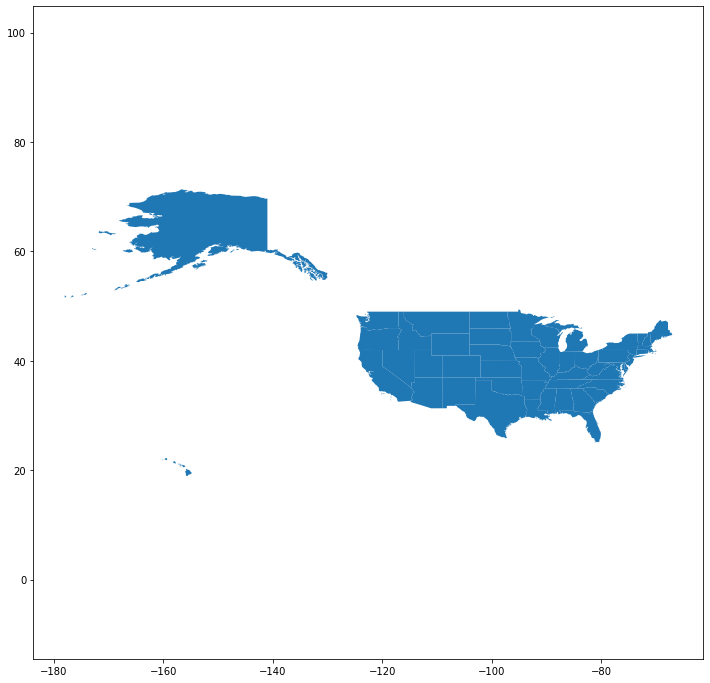

In [26]:
# cited from Week7 codes in Spatial Data Analysis(7CUSMSDA)
us_map=gpd.read_file('./shapefile/US_MAP/USA_States.shp')
# Setup figure and axis with different size
f, ax = plt.subplots(1, figsize=(12, 12))
# Add layer of polygons on the axis
us_map.plot(ax=ax)  # you code here 
plt.axis('equal')
# Display
plt.show() 

# 2.2 Get broadband speed data

In [27]:
us_speed_df = read_csv('./raw_data/broadband_speed_data/2020_Speed_USA.csv').dropna().reset_index(drop=True)

In [28]:
us_map = us_map.rename(columns={'STATE_ABBR':'State','STATE_NAME':'Name'})

In [29]:
# Merging data sets
us_merge_df = pd.merge(us_map,us_speed_df)

In [30]:
us_merge_df

,Name,STATE_FIPS,State,geometry,Consumer,Max Advertised Downstream Speed (mbps),Max Advertised Upstream Speed (mbps),Business
0,Washington,53,WA,"MULTIPOLYGON (((-122.40202 48.22522, -122.4628...",0.854811,129.423680,39.785421,0.964202
1,Montana,30,MT,"POLYGON ((-111.47543 44.70216, -111.48080 44.6...",0.821990,67.172414,17.143527,0.991153
2,Maine,23,ME,"MULTIPOLYGON (((-69.77728 44.07415, -69.85993 ...",0.835883,97.425515,9.581881,0.850205
3,North Dakota,38,ND,"POLYGON ((-98.73044 45.93827, -99.00683 45.939...",0.814570,220.210011,145.523117,0.999665
4,South Dakota,46,SD,"POLYGON ((-102.78838 42.99530, -103.00588 42.9...",0.838557,110.609592,54.947356,0.991217
5,Wyoming,56,WY,"POLYGON ((-104.05362 41.69822, -104.05550 41.5...",0.831819,74.145181,26.632791,0.998752
6,Wisconsin,55,WI,"MULTIPOLYGON (((-87.74855 44.96162, -87.83999 ...",0.852172,100.144619,19.183223,0.809227
7,Idaho,16,ID,"POLYGON ((-117.02630 43.67903, -117.02379 43.7...",0.830606,67.135852,13.149049,0.983487
8,Vermont,50,VT,"POLYGON ((-73.25806 42.74606, -73.26928 42.747...",0.829648,98.048313,22.575740,0.965867
9,Minnesota,27,MN,"POLYGON ((-91.73037 43.49957, -92.07753 43.499...",0.851897,163.138822,90.362306,0.989799


# 2.3 Access to U.S. Carbon Emissions Dataset

In [31]:
USA_Carbon_df1 = read_csv('./raw_data/carbon_emissions_data/USA_Carbon_residential_2020.csv').dropna().reset_index(drop=True)
USA_Carbon_df2 = read_csv('./raw_data/carbon_emissions_data/USA_Carbon_transportation_2020.csv').dropna().reset_index(drop=True)

In [32]:
arr1 = USA_Carbon_df1.values
new_df1 = pd.DataFrame(arr1[1:,0:],columns=arr1[0,0:]).reset_index(drop=True)
new_df1 = new_df1.rename(columns={'State':'Name'})
new_df1.columns = new_df1.columns.astype(str)
arr2 = USA_Carbon_df2.values
new_df2 = pd.DataFrame(arr2[1:,0:],columns=arr2[0,0:]).reset_index(drop=True)
new_df2 = new_df2.rename(columns={'State':'Name'})
new_df2.columns = new_df2.columns.astype(str)

In [33]:
new_df1 = new_df1.loc[:,['Name','2019.0']]
new_df2 = new_df2.loc[:,['Name','2019']]

In [34]:
research_df2 =  pd.merge(us_merge_df,new_df1).rename(columns={'2019.0':'Residential CO2'})
us_df =  pd.merge(research_df2,new_df2).rename(columns={'2019':'Transport CO2'})
us_df['Transport CO2'] = us_df['Transport CO2'].astype(float)
us_df['Residential CO2'] = us_df['Residential CO2'].astype(float)

In [35]:
type(us_df['Transport CO2'][1])

numpy.float64

In [36]:
us_df['Average download speed (Mbit/s)'] = (us_df['Max Advertised Downstream Speed (mbps)'] + us_df['Max Advertised Upstream Speed (mbps)'])/2

In [37]:
us_df['Average download speed (Mbit/s)']=us_df['Average download speed (Mbit/s)'].astype(float)

In [38]:
# cited from Week7 codes in Spatial Data Analysis(7CUSMSDA) 
# Geographical coordinate conversion
crs = {'init': 'epsg:4326'}
us_gdf = gpd.GeoDataFrame(us_df, crs=crs)
# Mercator Projection
us_gdf = us_gdf.to_crs({'init': 'epsg:3857'})
us_gdf.to_file(driver='ESRI Shapefile', filename='./shapefile/US_MAP/us_gdf.shp')

In [39]:
us_gdf

,Name,STATE_FIPS,State,geometry,Consumer,Max Advertised Downstream Speed (mbps),Max Advertised Upstream Speed (mbps),Business,Residential CO2,Transport CO2,Average download speed (Mbit/s)
0,Washington,53,WA,"MULTIPOLYGON (((-13625730.047 6144404.965, -13...",0.854811,129.423680,39.785421,0.964202,6.1,46.6,84.604551
1,Montana,30,MT,"POLYGON ((-12409387.560 5574754.263, -12409986...",0.821990,67.172414,17.143527,0.991153,2.0,8.0,42.157970
2,Maine,23,ME,"MULTIPOLYGON (((-7767570.863 5476923.986, -777...",0.835883,97.425515,9.581881,0.850205,3.0,7.2,53.503698
3,North Dakota,38,ND,"POLYGON ((-10990621.962 5770462.623, -11021390...",0.814570,220.210011,145.523117,0.999665,1.3,9.7,182.866564
4,South Dakota,46,SD,"POLYGON ((-11442350.630 5311257.031, -11466561...",0.838557,110.609592,54.947356,0.991217,1.3,6.8,82.778474
5,Wyoming,56,WY,"POLYGON ((-11583195.459 5115880.651, -11583405...",0.831819,74.145181,26.632791,0.998752,1.0,8.0,50.388986
6,Wisconsin,55,WI,"MULTIPOLYGON (((-9768124.444 5615480.859, -977...",0.852172,100.144619,19.183223,0.809227,10.8,30.7,59.663921
7,Idaho,16,ID,"POLYGON ((-13027307.593 5415905.138, -13027029...",0.830606,67.135852,13.149049,0.983487,2.0,11.5,40.142451
8,Vermont,50,VT,"POLYGON ((-8155049.917 5273398.913, -8156298.4...",0.829648,98.048313,22.575740,0.965867,1.6,3.1,60.312027
9,Minnesota,27,MN,"POLYGON ((-10211377.652 5388323.553, -10250024...",0.851897,163.138822,90.362306,0.989799,10.2,33.7,126.750564


In [40]:
# type(us_gdf['Residential CO2'][1])

# 2.4 Spatial Autocorrelation in US

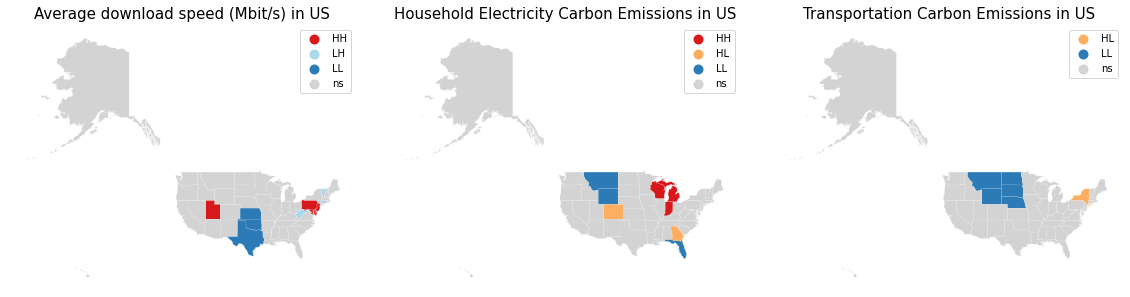

In [41]:
y1 = us_gdf['Average download speed (Mbit/s)'].values
y2 = us_gdf['Residential CO2'].values
y3 = us_gdf['Transport CO2'].values

w = lps.weights.distance.Kernel.from_dataframe(us_gdf, fixed=False, k=15)
w.transform = 'r'
lisa1 = esda.Moran_Local(y1, w)
lisa2 = esda.Moran_Local(y2, w)
lisa3 = esda.Moran_Local(y3, w)
fig,ax=plt.subplots(1,3,figsize=(20,12), subplot_kw=dict(aspect='equal'))
# cited from Week7 codes in Spatial Data Analysis(7CUSMSDA)
fig1 = lisa_cluster(lisa1, us_gdf, ax=ax[0])
ax[0].set_axis_off()
ax[0].set_title("Average download speed (Mbit/s) in US", size=15)

fig2 = lisa_cluster(lisa2, us_gdf, ax=ax[1])
ax[1].set_axis_off()
ax[1].set_title("Household Electricity Carbon Emissions in US", size=15)

fig3 = lisa_cluster(lisa3, us_gdf, ax=ax[2])
ax[2].set_axis_off()
ax[2].set_title("Transportation Carbon Emissions in US", size=15)
# Household Electricity Carbon Emissions in UK
# Transportation Carbon Emissions in UK
plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=-0.3)
plt.show()

# 2.5 Drawing partition images

In [42]:
imdfj = ps.viz.mapclassify.FisherJenks(us_gdf['Average download speed (Mbit/s)'], k=5)
imdfj

FisherJenks             

    Interval       Count
------------------------
[ 40.14,  60.31] |    14
( 60.31,  84.60] |    19
( 84.60, 110.03] |    10
(110.03, 144.20] |     4
(144.20, 205.62] |     4

In [43]:
# us_gdf

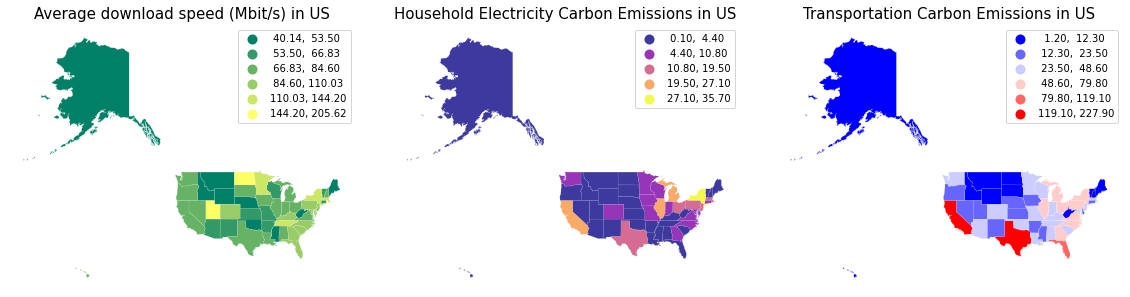

In [44]:
fig,ax=plt.subplots(1,3,figsize=(20,12), subplot_kw=dict(aspect='equal'))
# cited from Week7 codes in Spatial Data Analysis(7CUSMSDA)
fig1 = us_gdf.plot(column='Average download speed (Mbit/s)', scheme='FisherJenks', alpha=1, k=6, \
         cmap='summer', 
         edgecolor='w', linewidth=0.1,ax=ax[0], legend=True)
ax[0].set_axis_off()
ax[0].set_title("Average download speed (Mbit/s) in US", size=15)


fig2 = us_gdf.plot(column='Residential CO2', scheme='FisherJenks', alpha=0.8, k=5, \
         cmap='plasma', 
         edgecolor='w', linewidth=0.1,ax=ax[1], legend=True)
ax[1].set_axis_off()
ax[1].set_title("Household Electricity Carbon Emissions in US", size=15)

fig3 = us_gdf.plot(column='Transport CO2', scheme='FisherJenks', alpha=1, k=6, \
         cmap='bwr', 
         edgecolor='w', linewidth=0.1,ax=ax[2], legend=True)
ax[2].set_axis_off()
ax[2].set_title("Transportation Carbon Emissions in US", size=15)
# Household Electricity Carbon Emissions in UK
# Transportation Carbon Emissions in UK
plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=-0.3)
plt.show()

# 3.1 Get a map of China

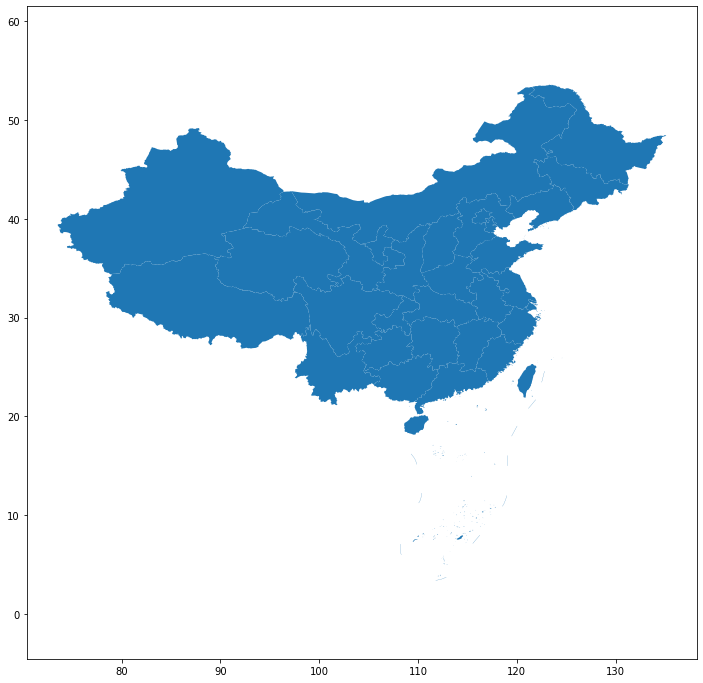

In [45]:
# cited from Week7 codes in Spatial Data Analysis(7CUSMSDA)
ch_map=gpd.read_file('./shapefile/CH_MAP/China_map.shp')
# Setup figure and axis with different size
f, ax = plt.subplots(1, figsize=(12, 12))
# Add layer of polygons on the axis
ch_map.plot(ax=ax)  # you code here 
plt.axis('equal')
# Display
plt.show() 

In [46]:
ch_map = ch_map.drop(columns=['name', 'center','centroid','subFeature','acroutes','adchar','level','parent'])
ch_map = ch_map.dropna()
ch_map['adcode'] = ch_map['adcode'].astype(int)

In [47]:
# ch_map

# 3.2 Get China Broadband Data

In [48]:
ch_speed_df = read_csv('./raw_data/broadband_speed_data/2020_Speed_CH.csv').dropna().reset_index(drop=True)

In [49]:
ch_speed_df

,adcode,name,Average upload speed(Mbps),Average download speed(Mbps)
0,110000,Beijing,39.88,276.14
1,120000,Tianjin City,38.04,184.84
2,130000,Hebei Province,43.75,251.89
3,140000,Shanxi Province,43.09,301.33
4,150000,Inner Mongolia Autonomous Region,40.31,213.23
5,210000,Liaoning Province,40.40,219.27
6,220000,Jilin Province,58.79,310.73
7,230000,Heilongjiang Province,48.38,264.78
8,310000,Shanghai,40.82,201.82
9,320000,Jiangsu Province,32.68,167.33


# 3.3 Get China carbon emissions data

In [50]:
ch_carbon_df = read_csv('./raw_data/carbon_emissions_data/China_Carbon.csv').dropna().reset_index(drop=True)

In [51]:
# ch_carbon_df

In [52]:
ch_merge_df = pd.merge(ch_carbon_df,ch_speed_df)

In [53]:
# ch_merge_df

In [54]:
ch_df = pd.merge(ch_merge_df,ch_map)

In [55]:
ch_df

,adcode,name,Transportation Equipment(Mt CO2),Electronic and Telecommunications Equipment(Mt CO2),Total,Average upload speed(Mbps),Average download speed(Mbps),childrenNu,geometry
0,110000,Beijing,0.560757,0.120549,88.155437,39.88,276.14,16.0,"POLYGON ((117.38988 40.22796, 117.38372 40.188..."
1,120000,Tianjin City,0.483760,0.083518,158.466482,38.04,184.84,16.0,"MULTIPOLYGON (((117.76560 39.40053, 117.69970 ..."
2,130000,Hebei Province,0.766332,0.351237,914.209118,43.75,251.89,11.0,"MULTIPOLYGON (((115.72253 39.54420, 115.72130 ..."
3,140000,Shanxi Province,0.050867,0.046513,566.484251,43.09,301.33,11.0,"POLYGON ((110.37926 34.60061, 110.29549 34.610..."
4,150000,Inner Mongolia Autonomous Region,0.118483,0.006029,794.279375,40.31,213.23,12.0,"POLYGON ((97.17290 42.79526, 97.28254 42.78208..."
5,210000,Liaoning Province,0.715356,0.025662,533.388436,40.40,219.27,14.0,"MULTIPOLYGON (((119.85425 39.98857, 119.84563 ..."
6,220000,Jilin Province,1.153721,0.012008,203.661561,58.79,310.73,9.0,"POLYGON ((125.70752 40.86688, 125.68781 40.897..."
7,230000,Heilongjiang Province,0.410872,0.004946,278.211338,48.38,264.78,13.0,"POLYGON ((123.17848 46.24824, 123.14214 46.298..."
8,310000,Shanghai,1.175821,0.281927,192.912182,40.82,201.82,16.0,"MULTIPOLYGON (((120.90135 31.01733, 120.89088 ..."
9,320000,Jiangsu Province,1.242189,0.885268,804.594214,32.68,167.33,13.0,"POLYGON ((119.30607 35.07658, 119.29251 35.068..."


In [56]:
# Geographical coordinate conversion
crs = {'init': 'epsg:4326'}
ch_gdf = gpd.GeoDataFrame(ch_df, crs=crs)
ch_gdf = ch_gdf.to_crs({'init': 'epsg:3857'})
ch_gdf.to_file(driver='ESRI Shapefile', filename='./shapefile/CH_MAP/ch_gdf.shp')

# 3.4 Spatial Autocorrelation in China

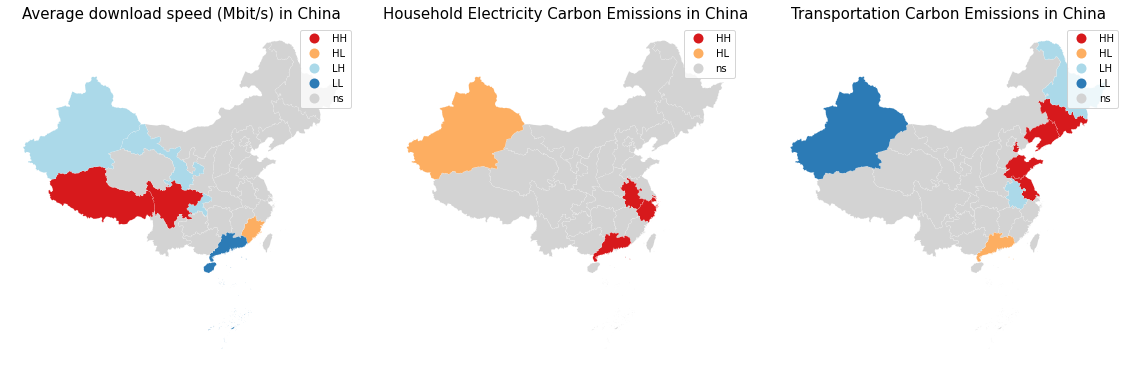

In [57]:
y1 = ch_gdf['Average download speed(Mbps)'].values
y2 = ch_gdf['Electronic and Telecommunications Equipment(Mt CO2)'].values
y3 = ch_gdf['Transportation Equipment(Mt CO2)'].values

w = lps.weights.distance.Kernel.from_dataframe(ch_gdf, fixed=False, k=15)
w.transform = 'r'
lisa1 = esda.Moran_Local(y1, w)
lisa2 = esda.Moran_Local(y2, w)
lisa3 = esda.Moran_Local(y3, w)
fig,ax=plt.subplots(1,3,figsize=(20,12), subplot_kw=dict(aspect='equal'))
# cited from Week7 codes in Spatial Data Analysis(7CUSMSDA)
fig1 = lisa_cluster(lisa1, ch_gdf, ax=ax[0])
ax[0].set_axis_off()
ax[0].set_title("Average download speed (Mbit/s) in China", size=15)

fig2 = lisa_cluster(lisa2, ch_gdf, ax=ax[1])
ax[1].set_axis_off()
ax[1].set_title("Household Electricity Carbon Emissions in China", size=15)

fig3 = lisa_cluster(lisa3, ch_gdf, ax=ax[2])
ax[2].set_axis_off()
ax[2].set_title("Transportation Carbon Emissions in China", size=15)
# Household Electricity Carbon Emissions in UK
# Transportation Carbon Emissions in UK
plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=-0.3)
plt.show()

# 3.5 Draw a zoning map

In [58]:
imdfj = ps.viz.mapclassify.FisherJenks(ch_gdf['Average download speed(Mbps)'], k=5)
imdfj

FisherJenks             

    Interval       Count
------------------------
[ 68.37, 111.70] |     3
(111.70, 219.27] |    11
(219.27, 264.78] |     8
(264.78, 316.03] |    11
(316.03, 421.82] |     1

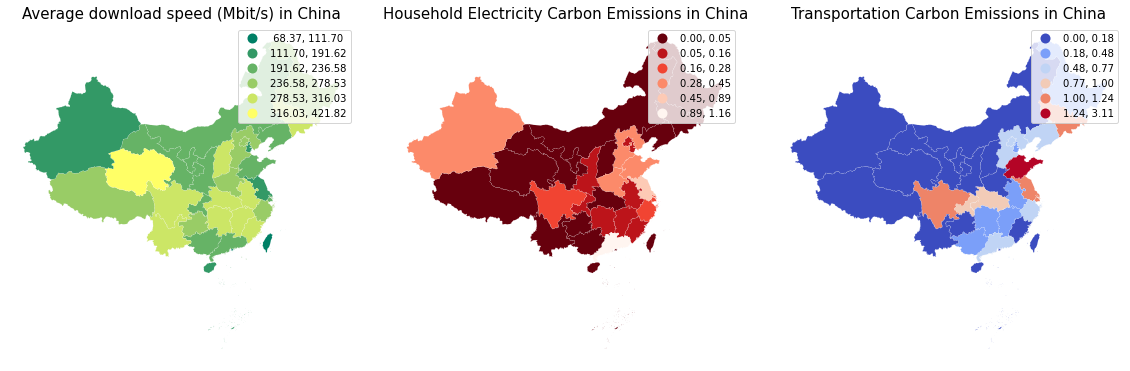

In [59]:
fig,ax=plt.subplots(1,3,figsize=(20,12), subplot_kw=dict(aspect='equal'))
# cited from Week7 codes in Spatial Data Analysis(7CUSMSDA)
fig1 = ch_gdf.plot(column='Average download speed(Mbps)', scheme='FisherJenks', alpha=1, k=6, \
         cmap='summer', 
         edgecolor='w', linewidth=0.1,ax=ax[0], legend=True)
ax[0].set_axis_off()
ax[0].set_title("Average download speed (Mbit/s) in China", size=15)


fig2 = ch_gdf.plot(column='Electronic and Telecommunications Equipment(Mt CO2)', scheme='FisherJenks', alpha=1, k=6, \
         cmap=plt.cm.Reds_r, 
         edgecolor='w', linewidth=0.1,ax=ax[1], legend=True)
ax[1].set_axis_off()
ax[1].set_title("Household Electricity Carbon Emissions in China", size=15)

fig3 = ch_gdf.plot(column='Transportation Equipment(Mt CO2)', scheme='FisherJenks', alpha=1, k=6, \
         cmap='coolwarm', 
         edgecolor='w', linewidth=0.1,ax=ax[2], legend=True)
ax[2].set_axis_off()
ax[2].set_title("Transportation Carbon Emissions in China", size=15)
# Household Electricity Carbon Emissions in UK
# Transportation Carbon Emissions in UK
plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=-0.3)
plt.show()

# 4 OLS Linear Regression

## 4.1 UK

In [60]:
# cited from Week7 codes in Spatial Data Analysis(7CUSMSDA)
# read the .dbf file from your shapefile data
uk_f = lps.io.open('./shapefile/UK_MAP/uk_gdf.dbf','r')
# Read in the Average download speed (Mbit/s) (dependent variable) into an array y
y = np.array(uk_f.by_col['Average do'])
y.shape = (len(y),1)
# value for independent variables into a one dimmensional array X. 
# You can feel free to change the independant variables
X= []
X.append(uk_f.by_col['Domestic E']) # Household Electricity Carbon Emissions in UK
X.append(uk_f.by_col['Transport']) # Transportation Carbon Emissions in UK

X = np.array(X).T


# GWR (UK)

In [61]:
#cited from: https://github.com/zarashabrina/gwr-mgwr-tutorial-stopsearch/blob/master/Stop-search%20GWR%20MGWR%20analysis.ipynb
#Coordinates for calibration points
def getXY(pt):
    return (pt.x, pt.y)
centroidseries = uk_gdf['geometry'].centroid
u,v = [list(t) for t in zip(*map(getXY, centroidseries))]

coords = list(zip(u,v))
#Prepare dataset inputs
g_y = uk_gdf['Average download speed (Mbit/s)'].values.reshape((-1,1))
g_X = uk_gdf[['Domestic Electricity', 'Transport Total']].values

g_coords = list(zip(u,v))

# Standardised our data to have mean of 0 and standard deviation of 1
g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)

g_y = g_y.reshape((-1,1))

g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)
labels =['Intercept','Household Electricity Carbon Emissions in UK', 'Transportation Carbon Emissions in UK']
from mgwr.sel_bw import Sel_BW

# Select bandwidth for kernel
bw = Sel_BW(g_coords, 
            g_y, # Independent variable
            g_X, # Dependent variable
            fixed=False, # True for fixed bandwidth and false for adaptive bandwidth
            spherical=True) # Spherical coordinates (long-lat) or projected coordinates
# calculate the optimum bandwidth for our local regression
bw.search(bw_min=2)
from mgwr.gwr import GWR
#Instantiate GWR model and then estimate parameters and diagnostics using fit method
model = GWR(coords, y, X, bw.bw[0])
results = model.fit()
#Results in a set of mappable results 
filtered_estimates = results.filter_tvals(alpha=.05)
filtered_estimates
data_params = pd.DataFrame(filtered_estimates)
data_localR2 = pd.DataFrame(results.localR2)
df1=pd.DataFrame(uk_gdf["Code"])
df2 = df1.assign(intercept=data_params[0],
                 Household_Electricity_Carbon_Emissions_UK=data_params[1],
                 Transportation_Carbon_Emissions_UK=data_params[2],
                 localR2=data_localR2[0])
df2.columns
df2

ct_shp = uk_gdf.merge(df2)
ct_shp.head()

,Code,laua_name,Domestic Electricity,Transport Total,Average download speed (Mbit/s),OBJECTID,LONG,LAT,SHAPE_Leng,SHAPE_Area,geometry,intercept,Household_Electricity_Carbon_Emissions_UK,Transportation_Carbon_Emissions_UK,localR2
0,E06000005,DARLINGTON,0.0324,0.1661,94.1,5,-1.56835,54.535339,107203.152334,1.974778e+08,"POLYGON ((423496.602 524724.299, 423497.204 52...",28.807166,3.053689,-2.051691,0.040867
1,E06000047,COUNTY DURHAM,0.1464,0.7686,45.4,45,-1.84050,54.685131,315062.780589,2.231457e+09,"POLYGON ((416954.896 558226.799, 416959.398 55...",28.316696,2.947967,0.000000,0.041490
2,E08000037,GATESHEAD,0.0541,0.3821,78.3,276,-1.68694,54.931149,89794.062372,1.423548e+08,"POLYGON ((415042.801 565083.296, 415104.202 56...",28.280769,2.834605,0.000000,0.040804
3,E06000001,HARTLEPOOL,0.0254,0.1232,100.1,1,-1.27018,54.676140,70995.722933,9.371703e+07,"MULTIPOLYGON (((450154.599 525938.201, 450140....",29.015607,3.013917,-2.023259,0.039800
4,E06000002,MIDDLESBROUGH,0.0364,0.2500,98.1,2,-1.21099,54.544670,44481.441385,5.388156e+07,"MULTIPOLYGON (((446854.700 517192.700, 446854....",29.168478,3.074960,-2.072302,0.039784


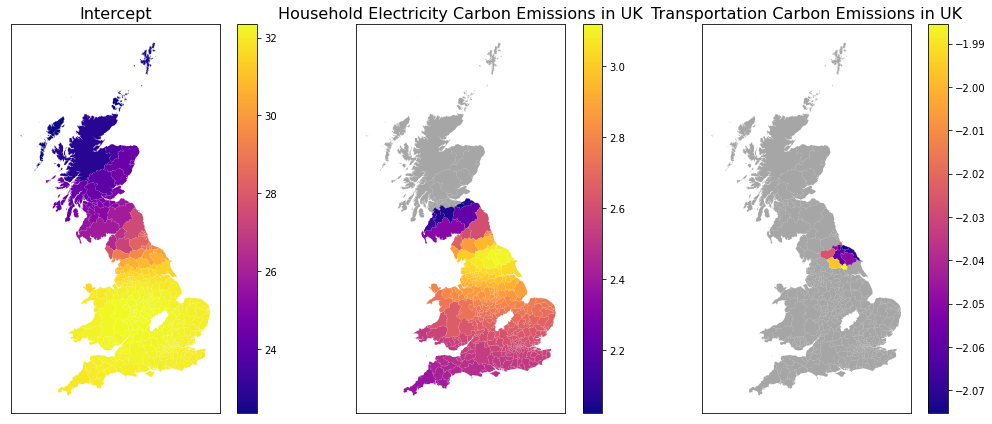

In [62]:
#cited from: https://github.com/zarashabrina/gwr-mgwr-tutorial-stopsearch/blob/master/Stop-search%20GWR%20MGWR%20analysis.ipynb

# First, let's create empty set of subplots with 2 rows and 3 columns
f,ax=plt.subplots(1,3,figsize=(15,6), subplot_kw=dict(aspect='equal'))
# Flatten them
ax = ax.flatten()
# Define the title of our plots
titles = ['Intercept','Household Electricity Carbon Emissions in UK', 'Transportation Carbon Emissions in UK']

# Here, we are creating loop for our parameter estimates 
for i,row in enumerate(filtered_estimates.T):
    # We want to plot all the non-significant estimates in grey
    ct_temp = ct_shp.assign(toplot=filtered_estimates.T[i])
    (ct_temp.query('toplot==0')
     .sort_values('toplot')
     .plot(color='grey',ax=ax[i],alpha=.7))
    # and assign colours only to the significant estimates
    (ct_temp.query('toplot!=0')
     .sort_values('toplot')
     .plot('toplot',
           cmap='plasma',
           ax=ax[i],
           legend=True))
    
    ax[i].set_title(titles[i], fontsize=16)
    
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
 
# For the last one, local R2, we can just map all of them regarding the significance

# (ct_shp.assign(r2=results.localR2)
#  .sort_values('r2')
#  .plot('r2',
#        ax=ax[-1],
#        legend=True,
#        vmin=0,
#        vmax=1,
#        cmap='Reds'))
    
# ax[-1].set_xticklabels([])
# ax[-1].set_yticklabels([])
# ax[-1].set_xticks([])
# ax[-1].set_yticks([])
    
# ax[-1].set_title('Local R2', fontsize=16)
    
f.tight_layout()
    
plt.show()

## 4.1.1 OLS (UK)

In [63]:
m1 = OLS(y, X, name_y = 'Average do', 
                        name_x = ['Domestic E', 'Transport'], 
                        name_ds = 'uk_gdf')
print(m1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :      uk_gdf
Weights matrix      :        None
Dependent Variable  :  Average do                Number of Observations:         360
Mean dependent var  :     69.1178                Number of Variables   :           3
S.D. dependent var  :     20.1635                Degrees of Freedom    :         357
R-squared           :      0.0191
Adjusted R-squared  :      0.0137
Sum squared residual:  143163.371                F-statistic           :      3.4842
Sigma-square        :     401.018                Prob(F-statistic)     :     0.03173
S.E. of regression  :      20.025                Log likelihood        :   -1588.233
Sigma-square ML     :     397.676                Akaike info criterion :    3182.465
S.E of regression ML:     19.9418                Schwarz criterion     :    3194.124

-----------------------------------------------------------------------------

## 4.1.2 SLM (UK)

In [64]:
uk_w_queen=Queen.from_shapefile('./shapefile/UK_MAP/uk_gdf.shp')
uk_spat_lag = ML_Lag(y,X,uk_w_queen,name_y='Average do', 
                  name_x=['Domestic E', 'Transport'],
                  name_w='uk_w_queen', name_ds='uk_gdf')
print(uk_spat_lag.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :      uk_gdf
Weights matrix      :  uk_w_queen
Dependent Variable  :  Average do                Number of Observations:         360
Mean dependent var  :     69.1178                Number of Variables   :           4
S.D. dependent var  :     20.1635                Degrees of Freedom    :         356
Pseudo R-squared    :      0.0258
Spatial Pseudo R-squared:  0.0055
Sigma-square ML     :     394.992                Log likelihood        :   -1587.112
S.E of regression   :      19.874                Akaike info criterion :    3182.223
                                                 Schwarz criterion     :    3197.768

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

## 4.1.3 SEM (UK)

In [65]:
uk_spat_err = ML_Error(y,X,uk_w_queen,name_y='Average do', 
                  name_x=['Domestic E', 'Transport'],
                  name_w='uk_w_queen', name_ds='uk_gdf')
print(uk_spat_err.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL ERROR (METHOD = FULL)
-------------------------------------------------------------------
Data set            :      uk_gdf
Weights matrix      :  uk_w_queen
Dependent Variable  :  Average do                Number of Observations:         360
Mean dependent var  :     69.1178                Number of Variables   :           3
S.D. dependent var  :     20.1635                Degrees of Freedom    :         357
Pseudo R-squared    :      0.0181
Sigma-square ML     :     321.480                Log likelihood        :   -1560.828
S.E of regression   :      17.930                Akaike info criterion :    3127.655
                                                 Schwarz criterion     :    3139.313

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------------------------------------

In [66]:
mses_uk = pd.Series({'OLS': mse(y, m1.predy.flatten()), 
                  'SL': mse(y, uk_spat_lag.predy.flatten()), 
                  'SE': mse(y, uk_spat_err.predy.flatten())
                    })
mses_uk.sort_values()

SL     394.992363
OLS    397.676031
SE     403.839989
dtype: float64

## US

In [67]:
#cited from: https://github.com/zarashabrina/gwr-mgwr-tutorial-stopsearch/blob/master/Stop-search%20GWR%20MGWR%20analysis.ipynb
import statsmodels.api as sm
# read the .dbf file from your shapefile data
us_f = lps.io.open('./shapefile/US_MAP/us_gdf.dbf','r')
# Read in the Average download speed (Mbit/s) (dependent variable) into an array y
y = np.array(us_f.by_col['Average do']).astype(float)
y.shape = (len(y),1)
# value for independent variables into a one dimmensional array X. 
# You can feel free to change the independant variables
X= []
X.append(us_f.by_col['Residentia']) # Household Electricity Carbon Emissions in US
X.append(us_f.by_col['Transport']) # Transportation Carbon Emissions in US

X = np.array(X).T
# cited from Week7 codes in Spatial Data Analysis(7CUSMSDA)
x = ['Residential CO2', 'Transport CO2'] # define input/independant variables
X = us_gdf.loc[:, x].dropna()
# X = sm.add_constant(X)
y = np.array(us_gdf['Average download speed (Mbit/s)']) # define output/dependant variable
# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

eval_env: 1
eval_env: 1


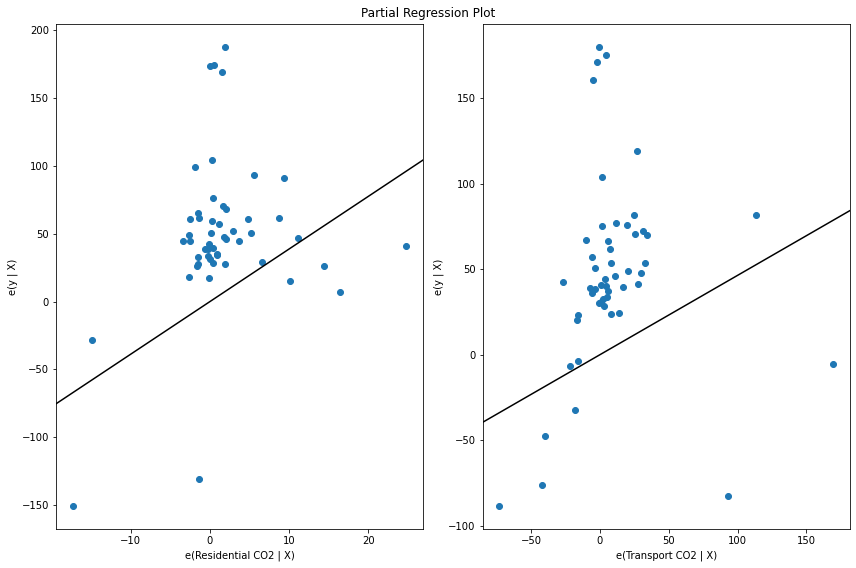

In [68]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(model, fig=fig)

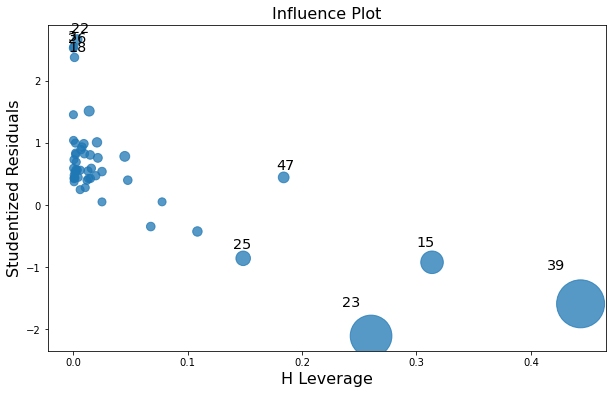

In [69]:
# visualize the influence from each borough
fig, ax = plt.subplots(figsize=(10,6))
fig = sm.graphics.influence_plot(model, ax=ax)

In [70]:
# read the .dbf file from your shapefile data
us_f = lps.io.open('./shapefile/US_MAP/us_gdf.dbf','r')
# Read in the Average download speed (Mbit/s) (dependent variable) into an array y
y = np.array(us_f.by_col['Average do']).astype(float)
y.shape = (len(y),1)
# value for independent variables into a one dimmensional array X. 
# You can feel free to change the independant variables
X= []
X.append(us_f.by_col['Residentia']) # Household Electricity Carbon Emissions in US
X.append(us_f.by_col['Transport']) # Transportation Carbon Emissions in US

X = np.array(X).T

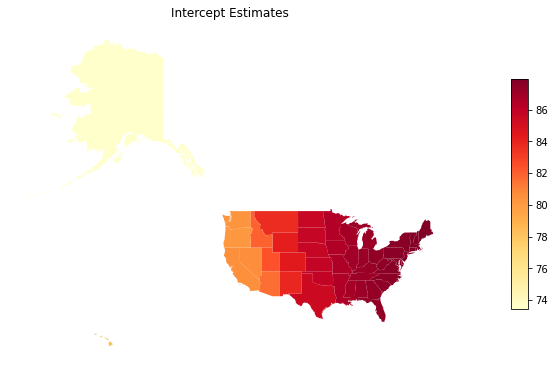

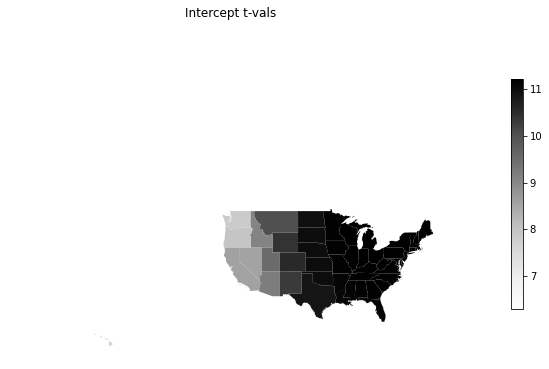

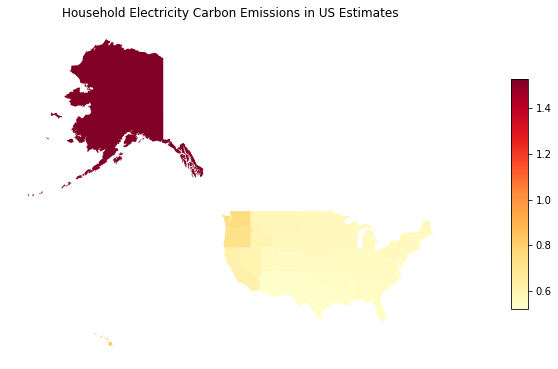

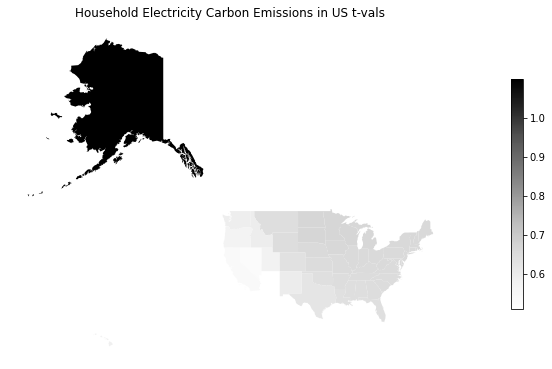

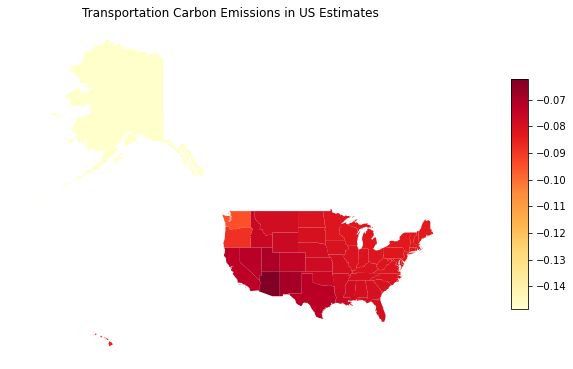

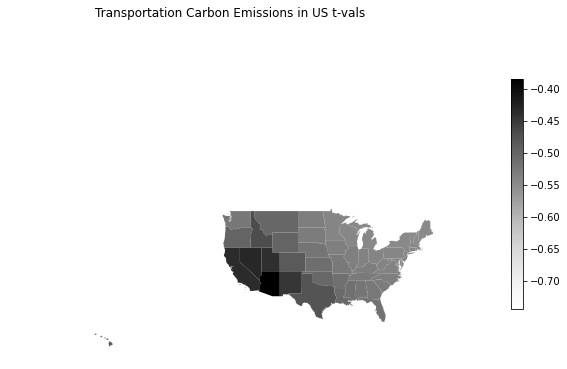

In [71]:
# cited by: https://github.com/zarashabrina/gwr-mgwr-tutorial-stopsearch/blob/master/Stop-search%20GWR%20MGWR%20analysis.ipynb

#Coordinates for calibration points
def getXY(pt):
    return (pt.x, pt.y)
centroidseries = us_gdf['geometry'].centroid
u,v = [list(t) for t in zip(*map(getXY, centroidseries))]

coords = list(zip(u,v))
#Prepare dataset inputs
g_y = us_gdf['Average download speed (Mbit/s)'].values.reshape((-1,1))
g_X = us_gdf[['Residential CO2', 'Transport CO2']].values

g_coords = list(zip(u,v))

# Standardised our data to have mean of 0 and standard deviation of 1
g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)

g_y = g_y.reshape((-1,1))

g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)
labels =['Intercept','Household Electricity Carbon Emissions in US', 'Transportation Carbon Emissions in US']
from mgwr.sel_bw import Sel_BW

# Select bandwidth for kernel
bw = Sel_BW(g_coords, 
            g_y, # Independent variable
            g_X, # Dependent variable
            fixed=False, # True for fixed bandwidth and false for adaptive bandwidth
            spherical=True) # Spherical coordinates (long-lat) or projected coordinates
# calculate the optimum bandwidth for our local regression
bw.search(bw_min=2)
from mgwr.gwr import GWR
#Instantiate GWR model and then estimate parameters and diagnostics using fit method
model = GWR(coords, y, X, bw.bw[0])
results = model.fit()

#Map Parameter estimates and T-vals for each covariate
for param in range(results.params.shape[1]):
    us_gdf[str(param)] = results.params[:,param]
    vmin, vmax = np.min(us_gdf[str(param)]), np.max(us_gdf[str(param)]) 
    ax = us_gdf.plot(str(param), vmin=vmin, vmax=vmax, figsize=(8,8), cmap='YlOrRd')
    ax.set_title(labels[param] + ' Estimates')
    ax.set_axis_off()
    fig = ax.get_figure()
    cax = fig.add_axes([1.0, 0.3, 0.03, 0.4])
    sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap='YlOrRd')
    sm._A = []
    fig.colorbar(sm, cax=cax)
    
    us_gdf[str(param)] = results.tvalues[:,param]
    vmin, vmax = np.min(us_gdf[str(param)]), np.max(us_gdf[str(param)]) 
    ax = us_gdf.plot(str(param), vmin=vmin, vmax=vmax, figsize=(8,8), cmap='Greys')
    ax.set_title(labels[param] + ' t-vals')
    ax.set_axis_off()
    fig = ax.get_figure()
    cax = fig.add_axes([1.0, 0.3, 0.02, 0.4])
    sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap='Greys')
    sm._A = []
    fig.colorbar(sm, cax=cax)

In [72]:
# data_params = pd.DataFrame(filtered_estimates)
# data_localR2 = pd.DataFrame(results.localR2)
# df1=pd.DataFrame(us_gdf["Name"])
# df2 = df1.assign(intercept=data_params[0],
#                  Household_Electricity_Carbon_Emissions_US=data_params[1],
#                  Transportation_Carbon_Emissions_US=data_params[2],
#                  localR2=data_localR2[0])
# df2.columns
# df2

In [73]:
# ct_shp = us_gdf.merge(df2)
# ct_shp.head()

## OLS (US)

In [74]:
# read the .dbf file from your shapefile data
us_f = lps.io.open('./shapefile/US_MAP/us_gdf.dbf','r')
# Read in the Average download speed (Mbit/s) (dependent variable) into an array y
y = np.array(us_f.by_col['Average do']).astype(float)
y.shape = (len(y),1)
# value for independent variables into a one dimmensional array X. 
# You can feel free to change the independant variables
X= []
X.append(us_f.by_col['Residentia']) # Household Electricity Carbon Emissions in US
X.append(us_f.by_col['Transport']) # Transportation Carbon Emissions in US

X = np.array(X).T

In [75]:
m2 = OLS(y, X, name_y = 'Average do', 
                        name_x = ['Residentia','Transport'], 
                        name_ds = 'us_gdf')
print(m2.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :      us_gdf
Weights matrix      :        None
Dependent Variable  :  Average do                Number of Observations:          51
Mean dependent var  :     86.5078                Number of Variables   :           3
S.D. dependent var  :     37.2102                Degrees of Freedom    :          48
R-squared           :      0.0139
Adjusted R-squared  :     -0.0271
Sum squared residual:   68264.757                F-statistic           :      0.3394
Sigma-square        :    1422.182                Prob(F-statistic)     :      0.7139
S.E. of regression  :      37.712                Log likelihood        :    -255.949
Sigma-square ML     :    1338.525                Akaike info criterion :     517.897
S.E of regression ML:     36.5859                Schwarz criterion     :     523.693

-----------------------------------------------------------------------------

## SLM (US)

In [76]:
us_w_queen=Queen.from_shapefile('./shapefile/US_MAP/us_gdf.shp')
us_spat_lag = ML_Lag(y,X,us_w_queen,name_y='Average do', 
                  name_x=['Residentia','Transport'],
                  name_w='us_w_queen', name_ds='us_gdf')
print(us_spat_lag.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :      us_gdf
Weights matrix      :  us_w_queen
Dependent Variable  :  Average do                Number of Observations:          51
Mean dependent var  :     86.5078                Number of Variables   :           4
S.D. dependent var  :     37.2102                Degrees of Freedom    :          47
Pseudo R-squared    :      0.0176
Spatial Pseudo R-squared:  0.0164
Sigma-square ML     :    1333.571                Log likelihood        :    -255.869
S.E of regression   :      36.518                Akaike info criterion :     519.739
                                                 Schwarz criterion     :     527.466

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

## SEM (US)

In [77]:
us_spat_err = ML_Error(y,X,us_w_queen,name_y='Average do', 
                  name_x=['Residentia','Transport'],
                  name_w='us_w_queen', name_ds='us_gdf')
print(us_spat_err.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL ERROR (METHOD = FULL)
-------------------------------------------------------------------
Data set            :      us_gdf
Weights matrix      :  us_w_queen
Dependent Variable  :  Average do                Number of Observations:          51
Mean dependent var  :     86.5078                Number of Variables   :           3
S.D. dependent var  :     37.2102                Degrees of Freedom    :          48
Pseudo R-squared    :      0.0139
Sigma-square ML     :    1337.970                Log likelihood        :    -255.942
S.E of regression   :      36.578                Akaike info criterion :     517.884
                                                 Schwarz criterion     :     523.680

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------------------------------------

In [78]:
mses_us = pd.Series({'OLS': mse(y, m2.predy.flatten()), 
                  'SL': mse(y, us_spat_lag.predy.flatten()), 
                  'SE': mse(y, us_spat_err.predy.flatten())
                    })
mses_us.sort_values()

SL     1333.570859
OLS    1338.524641
SE     1338.539455
dtype: float64

## China

In [79]:
# cited from Week7 codes in Spatial Data Analysis(7CUSMSDA)
import statsmodels.api as sm
# read the .dbf file from your shapefile data
ch_f = lps.io.open('./shapefile/CH_MAP/ch_gdf.dbf','r')
# Read in the Average download speed (Mbit/s) (dependent variable) into an array y
y_ch = np.array(ch_f.by_col['Average do'])
y_ch.shape = (len(y_ch),1)
# value for independent variables into a one dimmensional array X. 
# You can feel free to change the independant variables
X_ch= []
X_ch.append(ch_f.by_col['Electronic']) # Household Electricity Carbon Emissions in US
X_ch.append(ch_f.by_col['Transporta']) # Transportation Carbon Emissions in US

X_ch = np.array(X_ch).T

In [80]:
# cited from Week7 codes in Spatial Data Analysis(7CUSMSDA)
x = ['Electronic and Telecommunications Equipment(Mt CO2)', 'Transportation Equipment(Mt CO2)'] # define input/independant variables
X_ch = ch_gdf.loc[:, x].dropna()
# X = sm.add_constant(X)
y_ch = np.array(ch_gdf['Average download speed(Mbps)']) # define output/dependant variable
# Note the difference in argument order
model = sm.OLS(y_ch, X_ch).fit()
predictions = model.predict(X_ch) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.387
Model:                            OLS   Adj. R-squared (uncentered):              0.348
Method:                 Least Squares   F-statistic:                              10.08
Date:                Sat, 06 Aug 2022   Prob (F-statistic):                    0.000402
Time:                        18:04:28   Log-Likelihood:                         -227.45
No. Observations:                  34   AIC:                                      458.9
Df Residuals:                      32   BIC:                                      462.0
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
=======================================================================================================================
                                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Electronic and Telecommunications Equipment(Mt CO2)   149.7559    141.998      1.055      0.299    -139.485     438.996
Transportation Equipment(Mt CO2)                      158.7794     54.779      2.899      0.007      47.198     270.361
==============================================================================
Omnibus:                       16.707   Durbin-Watson:                   0.832
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.755
Skew:                          -1.286   Prob(JB):                     1.15e-05
Kurtosis:                       6.074   Cond. No.                         3.40
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

eval_env: 1
eval_env: 1
eval_env: 1


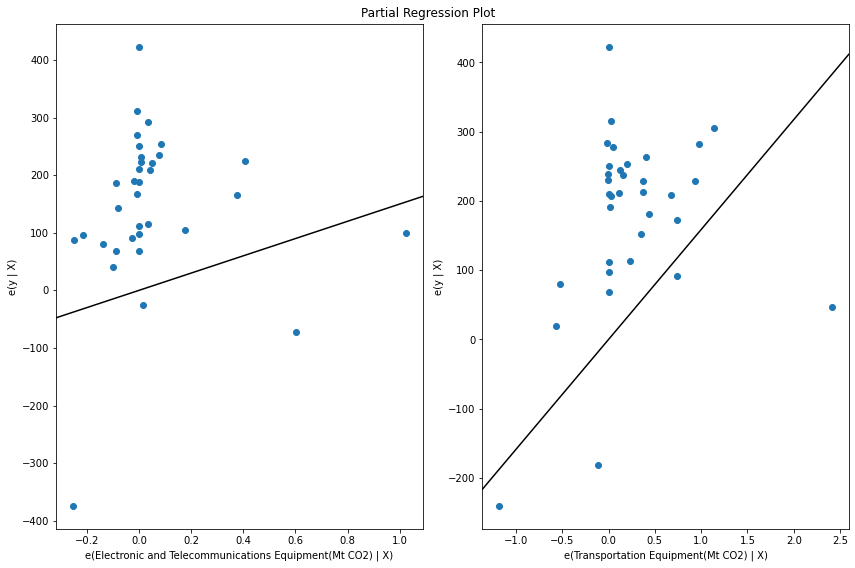

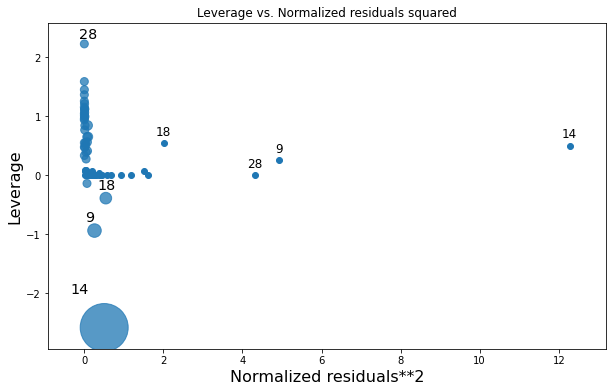

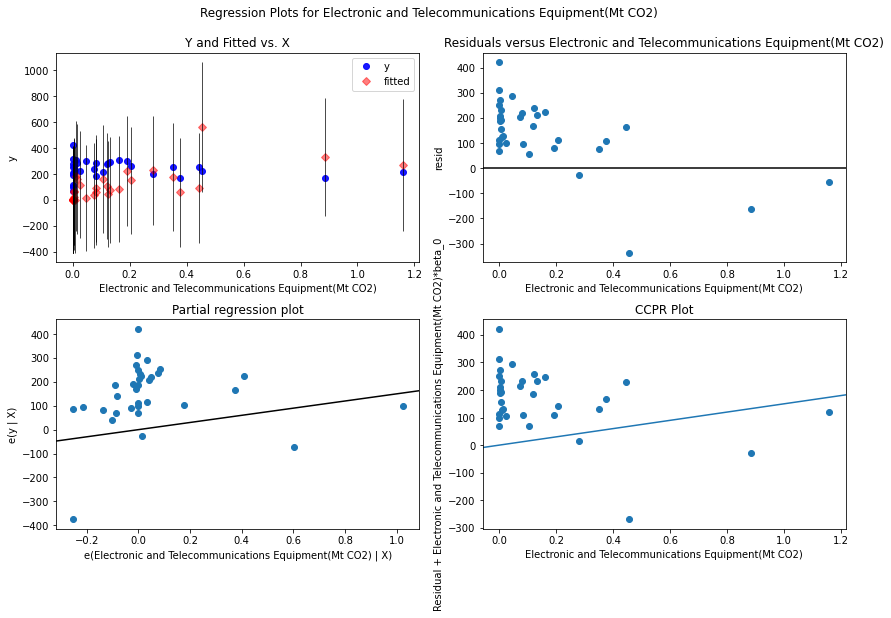

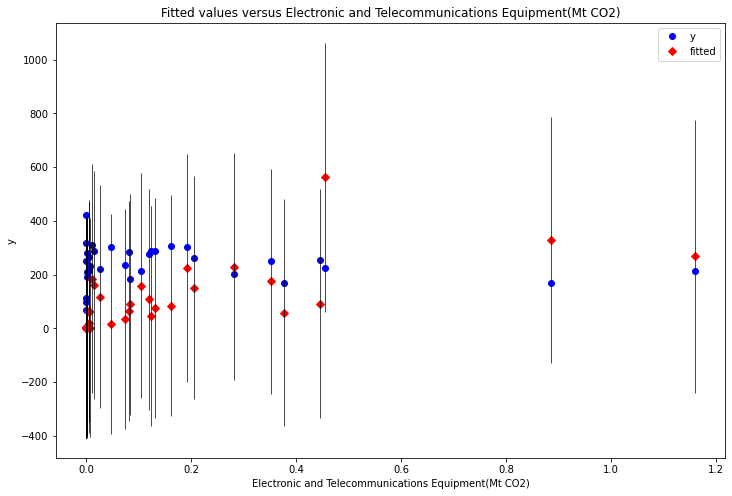

In [81]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(model, fig=fig)

# visualize the influence from each borough
fig, ax = plt.subplots(figsize=(10,6))
fig = sm.graphics.influence_plot(model, ax=ax)

fig = sm.graphics.plot_leverage_resid2(model, ax=ax)
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model, 'Electronic and Telecommunications Equipment(Mt CO2)', fig=fig)

fig, ax = plt.subplots(figsize=(12, 8))
fig = sm.graphics.plot_fit(model, "Electronic and Telecommunications Equipment(Mt CO2)", ax=ax)

## GWR (China)

In [82]:
# read the .dbf file from your shapefile data
ch_f = lps.io.open('./shapefile/CH_MAP/ch_gdf.dbf','r')
# Read in the Average download speed (Mbit/s) (dependent variable) into an array y
y = np.array(ch_f.by_col['Average do'])
y.shape = (len(y),1)
# value for independent variables into a one dimmensional array X. 
# You can feel free to change the independant variables
X= []
X.append(ch_f.by_col['Electronic']) # Household Electricity Carbon Emissions in US
X.append(ch_f.by_col['Transporta']) # Transportation Carbon Emissions in US

X = np.array(X).T

In [83]:
ch_gdf

,adcode,name,Transportation Equipment(Mt CO2),Electronic and Telecommunications Equipment(Mt CO2),Total,Average upload speed(Mbps),Average download speed(Mbps),childrenNu,geometry
0,110000,Beijing,0.560757,0.120549,88.155437,39.88,276.14,16.0,"POLYGON ((13067781.555 4899124.021, 13067095.8..."
1,120000,Tianjin City,0.483760,0.083518,158.466482,38.04,184.84,16.0,"MULTIPOLYGON (((13109606.848 4779207.101, 1310..."
2,130000,Hebei Province,0.766332,0.351237,914.209118,43.75,251.89,11.0,"MULTIPOLYGON (((12882173.224 4799926.062, 1288..."
3,140000,Shanxi Province,0.050867,0.046513,566.484251,43.09,301.33,11.0,"POLYGON ((12287362.683 4109737.500, 12278037.7..."
4,150000,Inner Mongolia Autonomous Region,0.118483,0.006029,794.279375,40.31,213.23,12.0,"POLYGON ((10817238.081 5280859.617, 10829442.8..."
5,210000,Liaoning Province,0.715356,0.025662,533.388436,40.40,219.27,14.0,"MULTIPOLYGON (((13342114.302 4864281.442, 1334..."
6,220000,Jilin Province,1.153721,0.012008,203.661561,58.79,310.73,9.0,"POLYGON ((13993697.449 4992725.837, 13991503.3..."
7,230000,Heilongjiang Province,0.410872,0.004946,278.211338,48.38,264.78,13.0,"POLYGON ((13712165.225 5820219.325, 13708119.8..."
8,310000,Shanghai,1.175821,0.281927,192.912182,40.82,201.82,16.0,"MULTIPOLYGON (((13458676.607 3634999.589, 1345..."
9,320000,Jiangsu Province,1.242189,0.885268,804.594214,32.68,167.33,13.0,"POLYGON ((13281090.516 4174292.664, 13279582.0..."


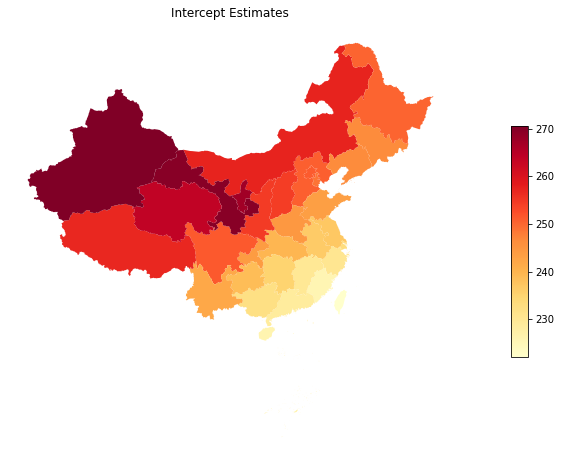

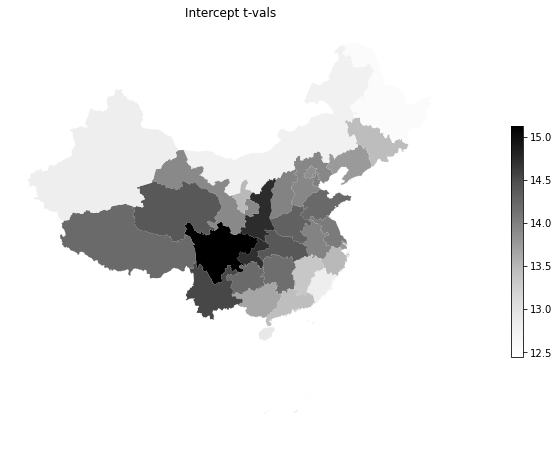

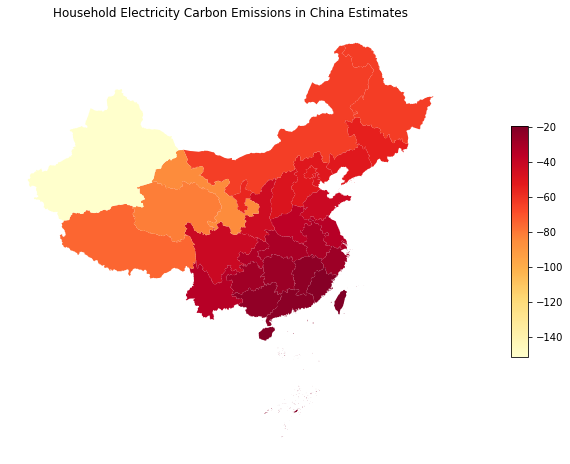

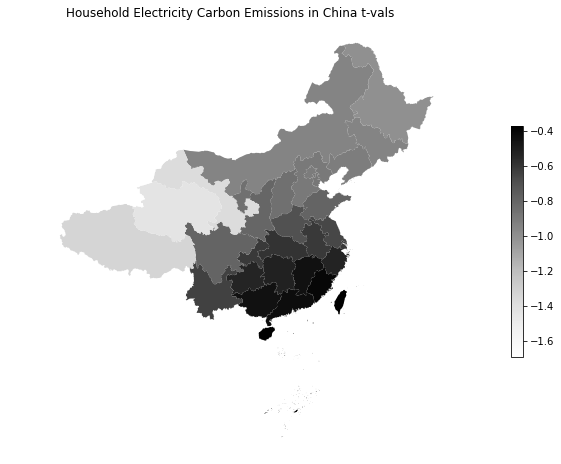

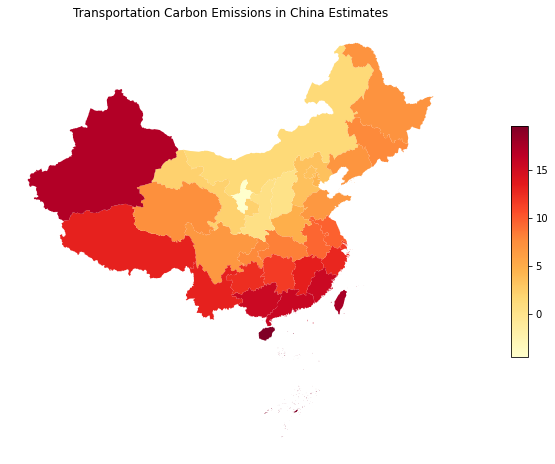

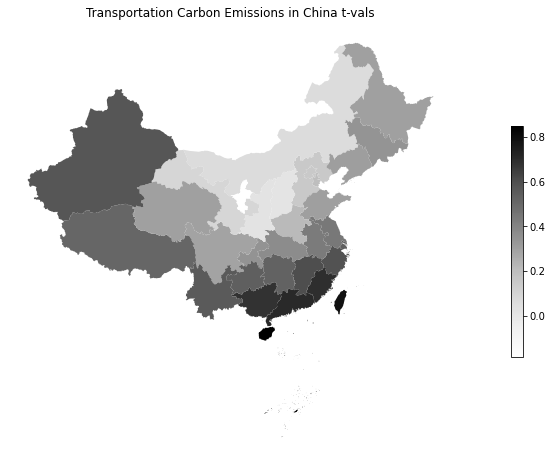

In [84]:
#cited from: https://github.com/zarashabrina/gwr-mgwr-tutorial-stopsearch/blob/master/Stop-search%20GWR%20MGWR%20analysis.ipynb
#Coordinates for calibration points
def getXY(pt):
    return (pt.x, pt.y)
centroidseries = ch_gdf['geometry'].centroid
u,v = [list(t) for t in zip(*map(getXY, centroidseries))]

coords = list(zip(u,v))
#Prepare dataset inputs
g_y = ch_gdf['Average download speed(Mbps)'].values.reshape((-1,1))
g_X = ch_gdf[['Electronic and Telecommunications Equipment(Mt CO2)', 'Transportation Equipment(Mt CO2)']].values

g_coords = list(zip(u,v))

# Standardised our data to have mean of 0 and standard deviation of 1
g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)

g_y = g_y.reshape((-1,1))

g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)
labels =['Intercept','Household Electricity Carbon Emissions in China', 'Transportation Carbon Emissions in China']
from mgwr.sel_bw import Sel_BW

# Select bandwidth for kernel
bw = Sel_BW(g_coords, 
            g_y, # Independent variable
            g_X, # Dependent variable
            fixed=False, # True for fixed bandwidth and false for adaptive bandwidth
            spherical=True) # Spherical coordinates (long-lat) or projected coordinates
# calculate the optimum bandwidth for our local regression
bw.search(bw_min=2)
from mgwr.gwr import GWR
#Instantiate GWR model and then estimate parameters and diagnostics using fit method
model = GWR(coords, y, X, bw.bw[0])
results = model.fit()

#Map Parameter estimates and T-vals for each covariate
for param in range(results.params.shape[1]):
    ch_gdf[str(param)] = results.params[:,param]
    vmin, vmax = np.min(ch_gdf[str(param)]), np.max(ch_gdf[str(param)]) 
    ax = ch_gdf.plot(str(param), vmin=vmin, vmax=vmax, figsize=(8,8), cmap='YlOrRd')
    ax.set_title(labels[param] + ' Estimates')
    ax.set_axis_off()
    fig = ax.get_figure()
    cax = fig.add_axes([1.0, 0.3, 0.03, 0.4])
    sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap='YlOrRd')
    sm._A = []
    fig.colorbar(sm, cax=cax)
    
    ch_gdf[str(param)] = results.tvalues[:,param]
    vmin, vmax = np.min(ch_gdf[str(param)]), np.max(ch_gdf[str(param)]) 
    ax = ch_gdf.plot(str(param), vmin=vmin, vmax=vmax, figsize=(8,8), cmap='Greys')
    ax.set_title(labels[param] + ' t-vals')
    ax.set_axis_off()
    fig = ax.get_figure()
    cax = fig.add_axes([1.0, 0.3, 0.02, 0.4])
    sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap='Greys')
    sm._A = []
    fig.colorbar(sm, cax=cax)

## OSL (China)

In [85]:
# read the .dbf file from your shapefile data
ch_f = lps.io.open('./shapefile/CH_MAP/ch_gdf.dbf','r')
# Read in the Average download speed (Mbit/s) (dependent variable) into an array y
y = np.array(ch_f.by_col['Average do'])
y.shape = (len(y),1)
# value for independent variables into a one dimmensional array X. 
# You can feel free to change the independant variables
X= []
X.append(ch_f.by_col['Electronic']) # Household Electricity Carbon Emissions in US
X.append(ch_f.by_col['Transporta']) # Transportation Carbon Emissions in US

X = np.array(X).T

In [86]:
m3 = OLS(y, X, name_y = 'Average do', 
                        name_x = ['Electronic','Transporta'], 
                        name_ds = 'ch_gdf')
print(m3.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :      ch_gdf
Weights matrix      :        None
Dependent Variable  :  Average do                Number of Observations:          34
Mean dependent var  :    238.9094                Number of Variables   :           3
S.D. dependent var  :     69.0867                Degrees of Freedom    :          31
R-squared           :      0.0313
Adjusted R-squared  :     -0.0312
Sum squared residual:  152579.146                F-statistic           :      0.5007
Sigma-square        :    4921.908                Prob(F-statistic)     :      0.6109
S.E. of regression  :      70.156                Log likelihood        :    -191.198
Sigma-square ML     :    4487.622                Akaike info criterion :     388.396
S.E of regression ML:     66.9897                Schwarz criterion     :     392.976

-----------------------------------------------------------------------------

## SLM (China)

In [87]:
ch_w_queen=Queen.from_shapefile('./shapefile/CH_MAP/ch_gdf.shp')
ch_spat_lag = ML_Lag(y,X,ch_w_queen,name_y='Average do', 
                  name_x=['Electronic','Transporta'],
                  name_w='ch_w_queen', name_ds='ch_gdf')
print(ch_spat_lag.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :      ch_gdf
Weights matrix      :  ch_w_queen
Dependent Variable  :  Average do                Number of Observations:          34
Mean dependent var  :    238.9094                Number of Variables   :           4
S.D. dependent var  :     69.0867                Degrees of Freedom    :          30
Pseudo R-squared    :      0.2580
Spatial Pseudo R-squared:  0.2771
Sigma-square ML     :    3439.680                Log likelihood        :    -186.919
S.E of regression   :      58.649                Akaike info criterion :     381.838
                                                 Schwarz criterion     :     387.943

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

## SEM (China)

In [88]:
ch_spat_err = ML_Error(y,X,ch_w_queen,name_y='Average do', 
                  name_x=['Electronic','Transporta'],
                  name_w='ch_w_queen', name_ds='ch_gdf')
print(ch_spat_err.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL ERROR (METHOD = FULL)
-------------------------------------------------------------------
Data set            :      ch_gdf
Weights matrix      :  ch_w_queen
Dependent Variable  :  Average do                Number of Observations:          34
Mean dependent var  :    238.9094                Number of Variables   :           3
S.D. dependent var  :     69.0867                Degrees of Freedom    :          31
Pseudo R-squared    :      0.0305
Sigma-square ML     :    4171.477                Log likelihood        :    -190.942
S.E of regression   :      64.587                Akaike info criterion :     387.884
                                                 Schwarz criterion     :     392.463

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------------------------------------

In [89]:
mses_ch = pd.Series({'OLS': mse(y, m3.predy.flatten()), 
                  'SL': mse(y, ch_spat_lag.predy.flatten()), 
                  'SE': mse(y, ch_spat_err.predy.flatten())
                    })
mses_ch.sort_values()

SL     3439.680122
OLS    4487.621946
SE     5332.668484
dtype: float64

Text(0.5, 0, "Moran's I")

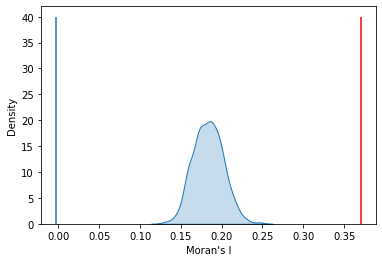

In [90]:
sns.kdeplot(mi.sim, shade=True)
plt.vlines(mi.I, 0, 40, color='r')
plt.vlines(mi.EI, 0, 40)
plt.xlabel("Moran's I")

In [91]:
mses_uk.sort_values()

SL     394.992363
OLS    397.676031
SE     403.839989
dtype: float64

In [92]:
mses_us.sort_values()

SL     1333.570859
OLS    1338.524641
SE     1338.539455
dtype: float64

In [93]:
mses_ch.sort_values()

SL     3439.680122
OLS    4487.621946
SE     5332.668484
dtype: float64